In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
#import pypianoroll as pr
#import pretty_midi
import os

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
def load_data_from_npz(filename):
    """Load and return the training data from a npz file (sparse format)."""
    with np.load(filename) as f:
        data = np.zeros(f['shape'], np.bool_)
        data[[x for x in f['nonzero']]] = True
    return data

In [8]:
data = load_data_from_npz('train_x_lpd_5_phr.npz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


In [9]:
data = data.reshape(102378, 4, 48, 420)
data = np.swapaxes(data, 1, 3)


In [10]:
data.shape

(102378, 420, 48, 4)

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(420, 48, 4))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [12]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 420, 48, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 210, 24, 32)  1184        ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 105, 12, 64)  18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 80640)        0           ['conv2d_5[0][0]']         

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(105*12*64, activation="relu")(latent_inputs)
x = layers.Reshape((105, 12, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(4, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [14]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 80640)             241920    
                                                                 
 reshape_1 (Reshape)         (None, 105, 12, 64)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 210, 24, 64)      36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 420, 48, 32)      18464     
 ranspose)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 420, 48, 4)        1156

In [15]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        # see below: kl_loss or Kullback–Leibler divergence

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [17]:
import numpy as np



vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
history = vae.fit(data, epochs=30, batch_size=128)

    

    

Epoch 1/30
800/800 [==============================] - 1598s 2s/step - total_loss: 1795.7321 - reconstruction_loss: 1782.9033 - kl_loss: 12.8308
Epoch 2/30
800/800 [==============================] - 1503s 2s/step - total_loss: 1380.1936 - reconstruction_loss: 1374.0693 - kl_loss: 6.1237
Epoch 3/30
800/800 [==============================] - 1527s 2s/step - total_loss: 1366.8640 - reconstruction_loss: 1360.6814 - kl_loss: 6.1821
Epoch 4/30
800/800 [==============================] - 1393s 2s/step - total_loss: 1350.7823 - reconstruction_loss: 1344.7733 - kl_loss: 6.0099
Epoch 5/30
800/800 [==============================] - 1450s 2s/step - total_loss: 1282.6942 - reconstruction_loss: 1275.4348 - kl_loss: 7.2590
Epoch 6/30
800/800 [==============================] - 1464s 2s/step - total_loss: 1249.5950 - reconstruction_loss: 1243.6759 - kl_loss: 5.9192
Epoch 7/30
800/800 [==============================] - 1439s 2s/step - total_loss: 1240.5261 - reconstruction_loss: 1235.4019 - kl_loss: 5.124

In [4]:
total_loss = np.asarray([1795.7321, 1380.1936, 1366.8640, 1350.7823, 1282.6942, 1249.5950, 1240.5261, 1236.0237, 1232.7563, 1229.7325, 1227.5891, 1225.2075, 1223.2814, 1221.2854, 1219.5289, 1217.7354, 1216.0542, 1214.5704, 1212.7928, 1211.4968, 1210.0194, 1208.6064, 1207.3363, 1206.2471, 1204.8787, 1204.0680, 1202.7902, 1201.6376, 1200.7271, 1199.7687])
recon_loss = np.asarray([1782.9033, 1374.0693, 1360.6814, 1344.7733, 1275.4348, 1243.6759, 1235.4019, 1231.2169, 1228.0643, 1225.1357, 1223.0399, 1220.6815, 1218.7782, 1216.8110, 1215.0919, 1213.3201, 1211.6857, 1210.2128, 1208.4591, 1207.1870, 1205.7271, 1204.3350, 1203.0900, 1202.0099, 1200.6488, 1199.8312, 1198.5688, 1197.4286, 1196.5282, 1195.5559])
kl_loss = total_loss-recon_loss
epoch = np.arange(1, 31)

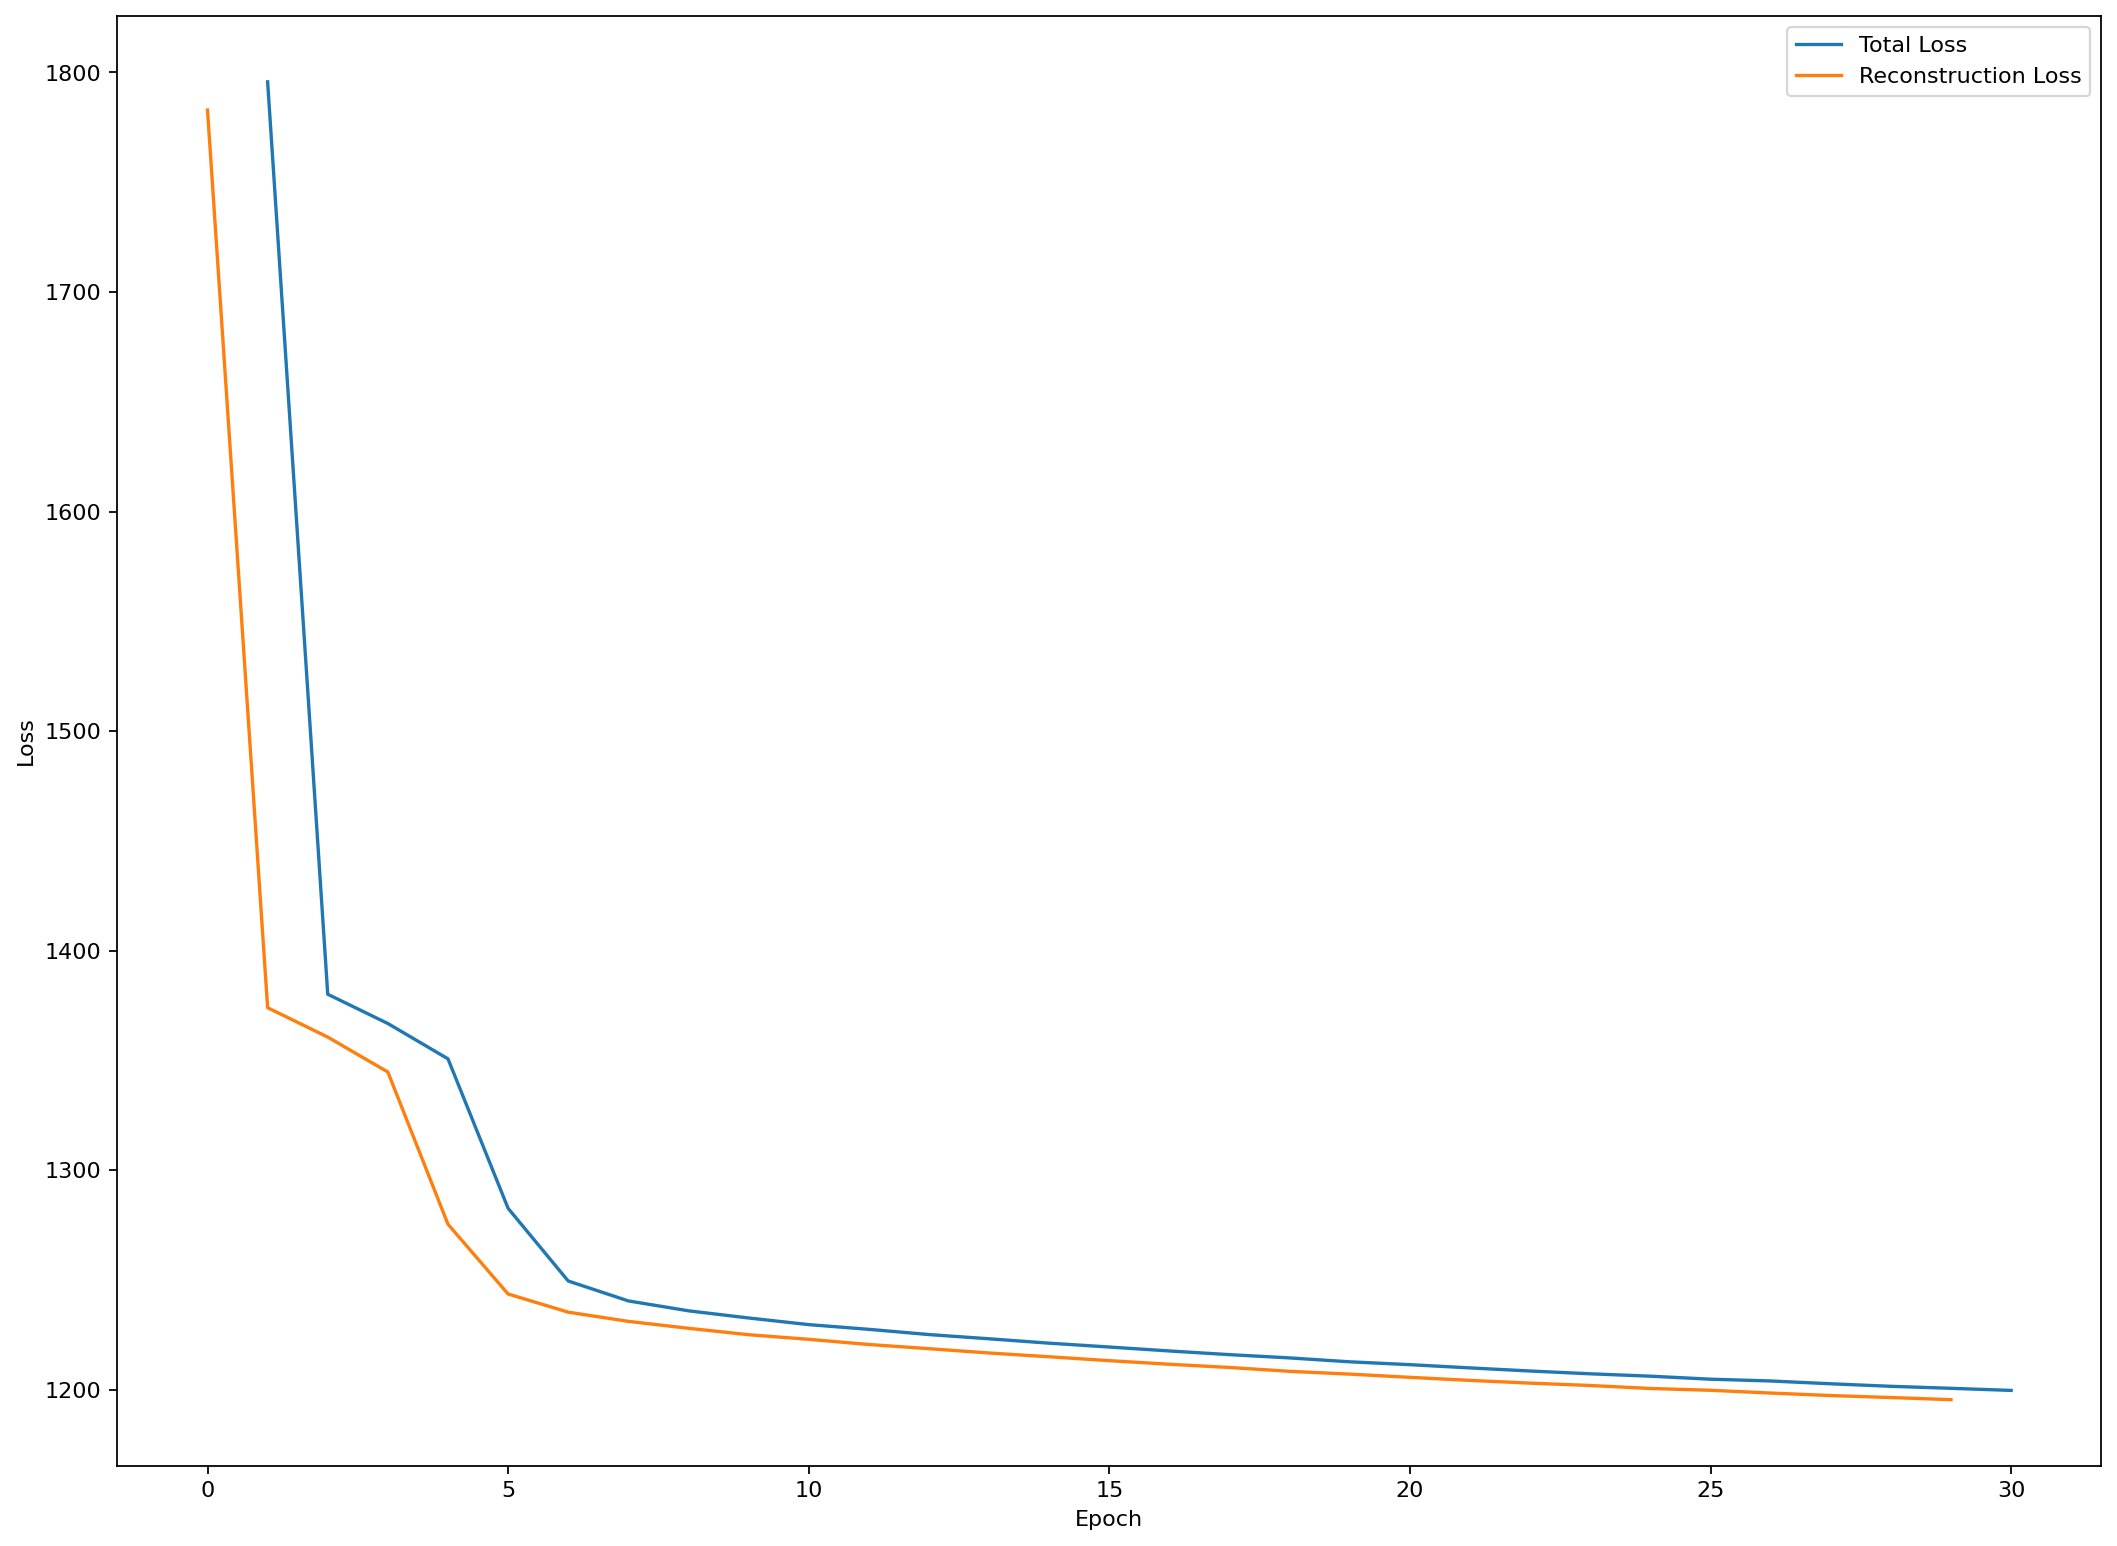

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
figure(figsize = (16,12), dpi = 160)
sns.set
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(epoch, total_loss)
plt.plot(recon_loss)
plt.legend(["Total Loss", "Reconstruction Loss"])

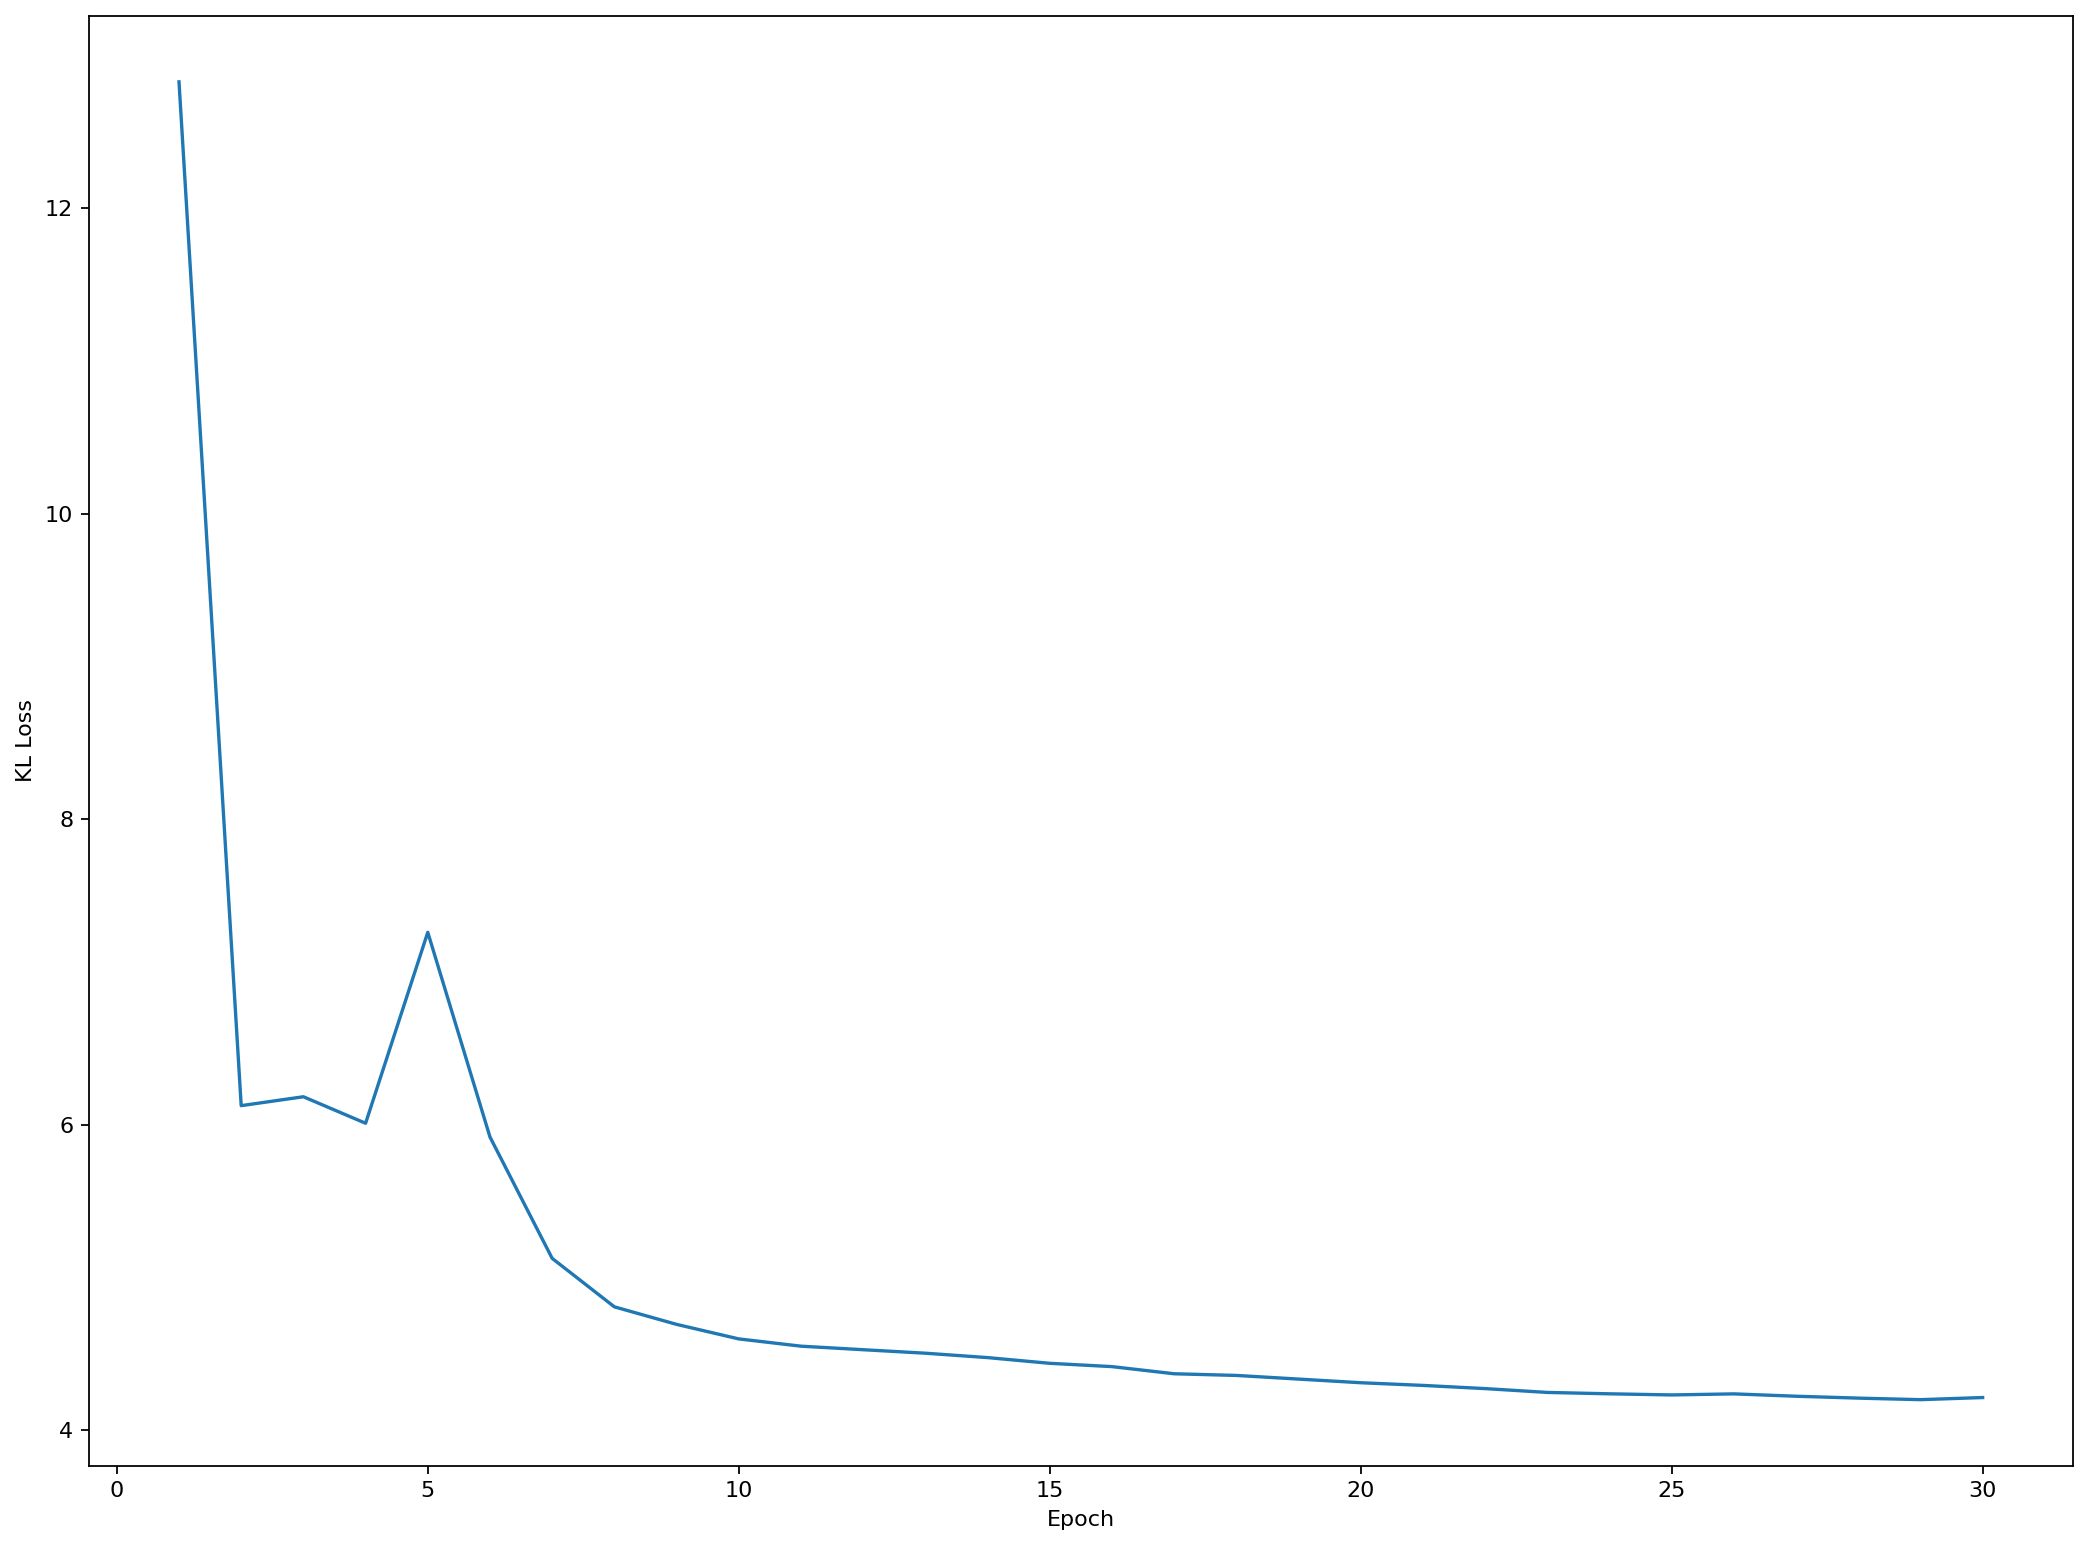

In [6]:
figure(figsize = (16,12), dpi = 160)
sns.set
plt.xlabel("Epoch")
plt.ylabel("KL Loss")

plt.plot(epoch, kl_loss)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir -p saved_model

In [25]:
vae.encoder.save('saved_model/encoder.h5')
vae.decoder.save('saved_model/decoder.h5')

AttributeError: ignored

In [3]:
loaded_encoder = tf.keras.models.load_model('encoder.h5')
loaded_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 420, 48, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 210, 24, 32)  1184        ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 105, 12, 64)  18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 80640)        0           ['conv2d_5[0][0]']         

In [27]:
data.shape

(102378, 420, 48, 4)

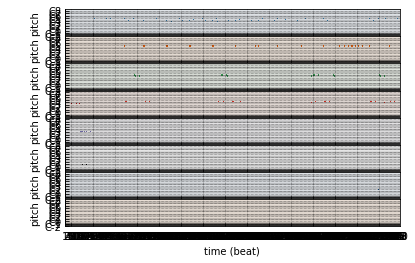

In [ ]:
import pypianoroll as pr
from pypianoroll import Multitrack
filepath = "test.mid"

multitrack = pr.read(filepath)
multitrack.trim(0, 4 * multitrack.resolution)
multitrack.binarize()
multitrack.plot()
multitrack.stack()